In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)
import time
import pickle

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense,Input,concatenate
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import lightgbm as lgb

from datetime import datetime, timedelta


from baseFunctions import *
from data_helpers import processData6, featureEngineering, getSequencesFast, removeOutliers, create_sequences


In [ ]:
data, propDicts, flippedPropDicts = processData6()
data, timeFeatures = featureEngineering(data,splits=[2,2,2,2])

In [ ]:
y_train, y_test, X_test.shape, X_train.shape

In [ ]:
np.savez('train_test_Sequences_100_16_StdNormalized_fam0-7.npz', arr1=X_train, arr2=y_train, arr3=std_train, arr4=X_test, arr5=y_test, arr6=std_test)

# LGBM

using a ln transformation and rmse vs. rmsle: -> maybe a bit less overfitting (0.628/0.561 vs. 0.581/0.588)

#familyId: 0 errors:   0.695 0.634


- familyId: 0 errors:   0.502 0.513  num round = 100, logTransform, look_back = 200 

- familyId: 0 errors:   0.692 0.632  num round = 10, logTransform, look_back = 200
 
- familyId: 0 errors:   0.683 0.625  num round = 10, log Transform, look_back = 400

- familyId: 0 errors:   0.496 0.512  num round = 100 log transform, look_back = 400

In [115]:
"""
create training data based on lagged features not 2 sequences
"""
trainF = [
       'store_nbr', 'family', 
       #'sales', 
       'onpromotion',# 'dataT',
       'city', 'state', 'type', 'cluster', 
       'dcoilwtico', 
       'holidayType',
       'description', 
       'transferred', 
       #'transactions', 
       'store_closed']
timeF = [
       'linear_time', 'day_of_year', 'day_of_year_f12_0', 'day_of_year_f104_0','day_of_year_f24_0',  'day_of_year_f52_0',
       'day_of_year_f12_180', 'day_of_year_f104_180','day_of_year_f24_180','day_of_year_f52_180', 
       'weekday', 'month'
       ]


def addArimaFeature(f, idx, n_predVal, df, ar, i, ma):
       train_subDf = df[[f]].iloc[0:idx] #idx excluded
       y_trainArima = train_subDf[[f]].fillna(0)

       model = ARIMA(y_trainArima, order=(ar, i, ma))
       model_fit = model.fit()
       
       fitted_values = model_fit.fittedvalues
       predicted_values = model_fit.forecast(steps=n_predVal)

       return predicted_values

def fillArimaDf(df, f, n_predVal, ar,i,ma):
       offset = 100
       output = np.zeros((offset,n_predVal))*np.nan
       for j in range(df.shape[0]-offset):
              idx = j+offset
              ret = np.reshape(addArimaFeature(f, idx, n_predVal, df, ar,i,ma), (1,n_predVal))
              output = np.concatenate((output, ret), axis=0)
       return output
       


n_predictedValues = 16
refLag = 21
zScoreNorm = False
logTransform = True
predictDiff = True
lags = 56
rolling = [7,14,21]

# Date string
date_string = "2016-07-01"#"2017-05-01"

log = {}

train = data.loc[(data.dataT == 'train')]# & (data.date > "2015-07-01")]

    
stdDict = {}
meanDict= {}
X_train = []
X_test  = []
y_train = []
y_test  = []
y_trainBase, y_trainBase = [], []
std_train, std_test = [], []
mean_train, mean_test = [], []
init= False
for familyId in [0]: #data.family.unique():
       # start with only some families
       if familyId > 8:
          continue

       print(familyId)
       familyDf = train.loc[train.family==familyId]  

       for storeId in data.store_nbr.unique():
              #print('store',storeId)
              storeDf = familyDf.loc[(familyDf.store_nbr == storeId)] 

              # ln tranformation
              if logTransform:
                     storeDf.loc[:,['salesOrig']] = storeDf.sales
                     storeDf.loc[:,['sales']] = np.log(storeDf.sales + 1)
              if zScoreNorm: # just use entire training data for now
                     std = storeDf['sales'].std()
                     mean = storeDf['sales'].mean()
                     storeDf.loc[:,'sales'] = (storeDf.sales - mean)/std

              

              if predictDiff:
                     storeDf.loc[:,['ref']] = storeDf['sales'].shift(refLag)  #28
                     storeDf.loc[:,['target']] = storeDf['sales'] - storeDf['ref']
              else:
                     storeDf.loc[:,['target']] = storeDf['sales']

              # lag features / how many past datapoints are we tain
              featuresForLag = ['target'] #+['transactionsArima','salesArima']
              lagF = []#trainF
              for i in range(lags):
                     lag = i+1#+n_predictedValues
                     newF = [featuresForLag[j] + '_lag' + str(lag) for j in range(len(featuresForLag))]
                     lagF = lagF + newF
                     storeDf.loc[:,newF] = storeDf[featuresForLag].shift(lag).to_numpy()

              # rolling features
              rollingF = []
              for rol in rolling:
                     for i in range(len(lagF)):
                            #if 'sales_t-16'  in lagF[i]:
                            if 'target'  in lagF[i]:
                                   fm = lagF[i]+'_rollingM' + str(rol)
                                   fs = lagF[i]+'_rollingS' + str(rol)
                                   rollingF.append(fm)
                                   rollingF.append(fs)
                                   storeDf.loc[:,[fm]] = storeDf[lagF[i]].rolling(rol).mean()#.copy()
                                   storeDf.loc[:,[fs]] = storeDf[lagF[i]].rolling(rol).std()#.copy()


              allF = lagF + rollingF + timeF + trainF

              # we get a matrix that predicts only 1 timestamp -> stride it
              storeDf = storeDf.iloc[lags+n_predictedValues+refLag+max(rolling)+1:-1]

              train_subDf = storeDf.loc[storeDf.date < date_string]
              test_subDf  = storeDf.loc[storeDf.date >= date_string]

              targetF = 'sales'
              baseTrain, baseTest = [],[]
              if predictDiff:
                  targetF = 'target'
                  y_trainBase0 = train_subDf[['ref']].to_numpy()
                  y_testBase0  = test_subDf[['ref']].to_numpy()


              X_train0 = train_subDf[allF].to_numpy()
              y_train0 = train_subDf[[targetF]].to_numpy()
              X_test0 =  test_subDf[allF].to_numpy()
              y_test0 =   test_subDf[[targetF]].to_numpy()       
              
              if init:
                     X_train = np.concatenate((X_train, X_train0), axis=0)
                     X_test  = np.concatenate((X_test,  X_test0), axis=0)
                     y_train = np.concatenate((y_train, y_train0), axis=0)
                     y_test  = np.concatenate((y_test,  y_test0), axis=0)
                     if zScoreNorm:
                            std_train = np.concatenate((std_train, np.ones(y_train0.shape)*std), axis=0)
                            std_test  = np.concatenate((std_test,  np.ones(y_test0.shape)*std), axis=0)
                            mean_train = np.concatenate((mean_train, np.ones(y_train0.shape)*mean), axis=0)
                            mean_test = np.concatenate((mean_test, np.ones(y_test0.shape)*mean), axis=0)
                     if predictDiff:
                            y_trainBase = np.concatenate((y_trainBase, y_trainBase0), axis=0)
                            y_testBase  = np.concatenate((y_testBase,  y_testBase0), axis=0)
              else:
                     X_train, X_test, y_train,y_test = X_train0, X_test0, y_train0, y_test0
                     if zScoreNorm:
                            std_train  =np.ones(y_train0.shape)*std
                            std_test   =np.ones(y_test0.shape)*std
                            mean_train =np.ones(y_train0.shape)*mean
                            mean_test  =np.ones(y_test0.shape)*mean
                     if predictDiff:
                            y_trainBase, y_testBase = y_trainBase0, y_testBase0
                     init=True 

if predictDiff:
       print(y_trainBase.shape, y_testBase.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

0
(62586, 1) (22086, 1)
(62586, 416) (22086, 416) (62586, 1) (22086, 1)


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/lightgbm/basic.py:335: UserWarning:

Converting column-vector to 1d array



[LightGBM] [Info] Total Bins 102906
[LightGBM] [Info] Number of data points in the train set: 62586, number of used features: 415
[LightGBM] [Info] Start training from score 0.006776
transform log True predict diff True
errors:  0.34540868733684893 0.4841211129475221


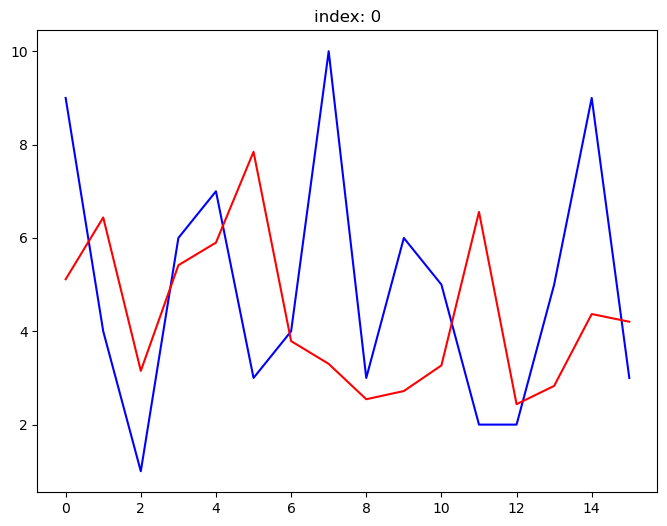

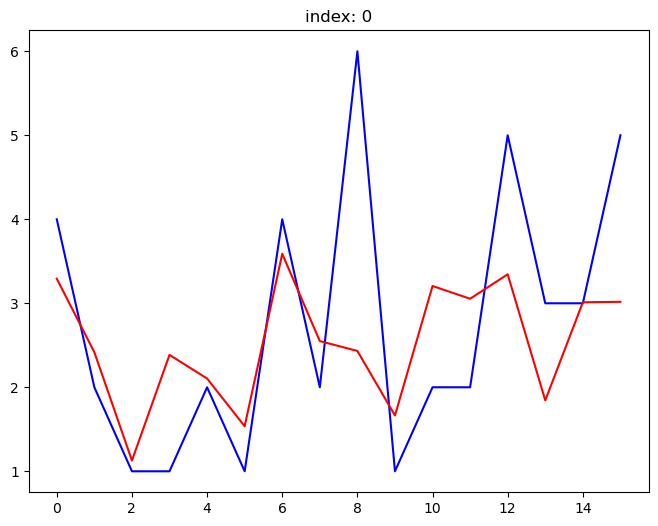

In [123]:
# family wise prediction does not generalize well either!

def calcLossLGBM(pred, y, logTransform, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred, (pred.shape[0],1)) + base
        y = y + base

    if logTransform:
        a = np.exp(pred)
        y = np.exp(y)
    else:
        a = (pred)
        y = (y)

    if (a < 0).any():
        a = np.clip(a, 0, 1e20)
    rmsleTrain = np.sqrt(mean_squared_log_error(a,y))
    return rmsleTrain
def plotLGBM(i, logTransform, pred, y, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred, (pred.shape[0],1)) + base
        y = y + base
    if logTransform:
        a = np.exp(pred[i:i+16])
        y = np.exp(y[i:i+16])
    else:
        a = (pred[i:i+16])
        y = (y[i:i+16])
    x = range(len(a))   

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axs.plot(x, y, color='blue',label='Original')
    axs.plot(x, a, color='red',label='pred')
    axs.set_title('index: '+str(i))
    fig.subplots_adjust(hspace=0.5)

# Set parameters for LGBM model
params = {
    'boosting':'gbdt',#'gbdt', #'rf' #'dart'
    'objective': 'regression',  # Assuming you're doing regression
    'metric': 'mse',  # Mean squared error
    'num_leaves': 15,
    'verbose': 1,
    'force_col_wise':True,
    'num_iterations':1000
}   

# Train the model
gbm = lgb.train(params, lgb.Dataset(X_train, label=y_train), valid_sets=[lgb.Dataset(X_test, label=y_test)]#,num_boost_round=100
#,callbacks=[lgb.early_stopping(stopping_rounds=30)]
)  
predtrainLGBM = gbm.predict(X_train)#, num_iteration=gbm.best_iteration)
predtestLGBM = gbm.predict(X_test)#, num_iteration=gbm.best_iteration)
print('transform log', logTransform, 'predict diff', predictDiff)
print('errors: ', calcLossLGBM(predtrainLGBM, y_train, logTransform, predictDiff, y_trainBase), calcLossLGBM(predtestLGBM, y_test, logTransform, predictDiff, y_testBase))

for i in range(1):
    plotLGBM(i*16, logTransform, predtestLGBM, y_test, predictDiff, y_testBase)
    plotLGBM(i*16, logTransform, predtrainLGBM, y_train, predictDiff, y_trainBase)


In [ ]:
# Set parameters for LGBM model
params = {
    'objective': 'regression',  # Assuming you're doing regression
    'metric': 'rmsle',  # Mean squared error
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}   

# Train the model
num_round = 10  
gbms = [lgb.train(params, lgb.Dataset(X_train, label=y_train[:, i]),num_round, valid_sets=[lgb.Dataset(X_test, label=y_test[:,i])]) for i in range(y_train.shape[1])]   


forecast = np.column_stack([gbm.predict(X_train, num_iteration=gbm.best_iteration) for gbm in gbms])
if (forecast<0).any():
    print('negative values!!!')
    forecast = np.clip(forecast, 0, 1e29)
if zScoreNorm:
    forecast = forecast *std_train  + mean_train
    y_train = y_train *std_train + mean_train
rmsleTrain = np.sqrt(mean_squared_log_error(forecast, y_train))
forecast = np.column_stack([gbm.predict(X_test, num_iteration=gbm.best_iteration) for gbm in gbms])
if zScoreNorm:
    forecast = forecast *std_test  + mean_test
    y_test = y_test*std_test + mean_test
rmsleTest = np.sqrt(mean_squared_log_error(forecast, y_test))
print('familyId:', familyId, 'errors:  ', round(rmsleTrain,3), round(rmsleTest,3), y_train.shape[0], y_test.shape[0])


In [ ]:
#LOG version
params = {
    'objective': 'regression',  # Assuming you're doing regression
    'metric': 'rmse',#'rmsle',  # Mean squared error
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}   

# Train the model
num_round = 100 
gbms = [lgb.train(params, lgb.Dataset(X_train, label=y_train[:, i]),num_round, valid_sets=[lgb.Dataset(X_test, label=y_test[:,i])]) for i in range(y_train.shape[1])]   


forecast = np.column_stack([gbm.predict(X_train, num_iteration=gbm.best_iteration) for gbm in gbms])
if logTransform:
    forecast0 = np.exp(forecast) - 1
    if (forecast0<0).any():
        print('negative values!!!')
        forecast0 = np.clip(forecast0, 0, 1e29)
    y_train0  = np.exp(y_train) - 1
    rmsleTrain = np.sqrt(mean_squared_log_error(forecast0, y_train0))
forecast = np.column_stack([gbm.predict(X_test, num_iteration=gbm.best_iteration) for gbm in gbms])
if logTransform:
    forecast1 = np.exp(forecast) - 1
    if (forecast1<0).any():
        print('negative values!!!')
        forecast1 = np.clip(forecast1, 0, 1e29)
    y_test1   = np.exp(y_test) - 1
    rmsleTest = np.sqrt(mean_squared_log_error(forecast1, y_test1))
print('familyId:', familyId, 'errors:  ', round(rmsleTrain,3), round(rmsleTest,3))


In [ ]:
#familyId: 0 errors:   0.695 0.634

# num round = 100, logTransform, look_back = 200
#familyId: 0 errors:   0.502 0.513
# num round = 10, logTransform, look_back = 200
#familyId: 0 errors:   0.692 0.632
# num round = 10, log Transform, look_back = 400
#familyId: 0 errors:   0.683 0.625
# num round = 100 log transform, look_back = 400
#familyId: 0 errors:   0.496 0.512

# facebook prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
# Assuming df is a pandas dataframe with 'ds' and 'y' columns
m = Prophet()
m.fit(df)

# Make future dataframe for 16 periods
future = m.make_future_dataframe(periods=16)
forecast = m.predict(future)


# Transformer

idea: we could use positional embeddings to define the relation between store and product

In [ ]:
# create training data for transformer / nn architectures
from data_helpers import create_sequences
def getSequencesFastNOTFlattened(train, trainF, look_back, n_predictedValues, zScoreNorm = False, logTransf=False, applyZScoreNorm = False, meanZ = 0, stdZ = 0,):
    # zscore over all values -> not ideal bc test data
    if zScoreNorm:
        #mean = train.sales.mean()
        mean = 0 # modified zScore, not in mean = 0
        std = max(train.sales.std(), 1)
        train.loc[:,'sales'] = (train.sales - mean) / std
    if applyZScoreNorm:
        train.loc[:,'sales'] = (train.sales-meanZ)/stdZ
    if logTransf:
        train.loc[:,'sales'] = np.log(train.sales + 1)

    trainF2 = trainF + ['sales']


    pastS   = create_sequences(train[trainF2].to_numpy(), look_back)                                   #past sequence
    futureS = create_sequences(train[trainF].iloc[look_back:-1].to_numpy(), n_predictedValues)        #future sequence
    label   = create_sequences(train[['sales']].iloc[look_back:-1].to_numpy(), n_predictedValues) #label

    maxLen = train.shape[0] - look_back-n_predictedValues
    pastS = pastS[0:maxLen,:,:].transpose([0,2,1])
    futureS = futureS[0:maxLen,:,:].transpose([0,2,1])
    label = label[0:maxLen,:].transpose([0,2,1])

    if zScoreNorm:
        return pastS, futureS, label, mean, std
    elif applyZScoreNorm:
        return pastS, futureS, label
    else:
        return pastS, futureS, label

trainF = [
       'store_nbr', 'family', 
       #'sales', 
       'onpromotion',# 'dataT',
       'city', 'state', 'type', 'cluster', 'dcoilwtico', 'holidayType',
       'description', 'transferred', 
       #'transactions', 
       'store_closed',
       'linear_time', 'day_of_year', 'day_of_year_f12_0', 'day_of_year_f104_0',
       'day_of_year_f24_0', 'day_of_year_f52_0', 'weekday', 'month'
       ]

trainF2 = trainF + ['sales']



n_predictedValues = 16
look_back = 100
zScoreNorm = False
logTransform = True

# Date string
date_string = "2017-05-01"
date_object = datetime.strptime(date_string, '%Y-%m-%d')
days_ago = date_object - timedelta(days=(look_back + n_predictedValues -1 +2))
days_ago_string = days_ago.strftime('%Y-%m-%d')
days_ago_string

maskTrain = data.date < date_string
maskTest = data.date  > days_ago_string #"2017-03-03" #42days + 15 day between (15 because we only want to iterate one value more from the test set)

log = {}

train = data.loc[data.dataT == 'train']

    

    
stdDict = {}
meanDict= {}
X_trainS0 = []
X_testS0  = []
X_trainS1 = []
X_testS1  = []
y_train = []
y_test  = []
std_train, std_test = [], []
mean_train, mean_test = [], []
init= False
for familyId in [0]: #data.family.unique():
       print(familyId)
       familyDf = train.loc[train.family==familyId]  

       for storeId in data.store_nbr.unique():
              if storeId >1:
                continue
              print(storeId)
              storeDf = familyDf.loc[(familyDf.store_nbr == storeId)] 
              if zScoreNorm:
                X_train0,X_train1,y_train0,mean,std = getSequencesFastNOTFlattened(storeDf.loc[maskTrain], trainF, look_back, n_predictedValues, zScoreNorm=zScoreNorm)
                X_test0,X_test1, y_test0            = getSequencesFastNOTFlattened(storeDf.loc[maskTest], trainF, look_back, n_predictedValues, zScoreNorm=False, applyZScoreNorm=True, meanZ=mean, stdZ=std)       
                stdDict[storeId] = std
                meanDict[storeId] = mean
              else:
                X_train0,X_train1,y_train0 = getSequencesFastNOTFlattened(storeDf.loc[maskTrain], trainF, look_back, n_predictedValues, zScoreNorm=False, logTransf=logTransform)
                X_test0,X_test1, y_test0   = getSequencesFastNOTFlattened(storeDf.loc[maskTest], trainF, look_back, n_predictedValues, zScoreNorm=False, logTransf=logTransform, applyZScoreNorm=False, meanZ=0, stdZ=0) 
              if init:
                     X_trainS0 = np.concatenate((X_trainS0, X_train0), axis=0)
                     X_testS0  = np.concatenate((X_testS0,  X_test0), axis=0)
                     X_trainS1 = np.concatenate((X_trainS1, X_train1), axis=0)
                     X_testS1  = np.concatenate((X_testS1,  X_test1), axis=0)
                     y_train = np.concatenate((y_train, y_train0), axis=0)
                     y_test  = np.concatenate((y_test,  y_test0), axis=0)
                     if  zScoreNorm:
                        std_train = np.concatenate((std_train, np.ones(y_train0.shape)*std), axis=0)
                        std_test  = np.concatenate((std_test,  np.ones(y_test0.shape)*std), axis=0)
                        mean_train = np.concatenate((mean_train, np.ones(y_train0.shape)*mean), axis=0)
                        mean_test = np.concatenate((mean_test, np.ones(y_test0.shape)*mean), axis=0)
              else:
                     X_trainS0, X_trainS1 = X_train0, X_train1
                     X_testS0, X_testS1   = X_test0, X_test1
                     y_train,y_test = y_train0, y_test0
                     if zScoreNorm:
                        std_train  =np.ones(y_train0.shape)*std
                        std_test   =np.ones(y_test0.shape)*std
                        mean_train =np.ones(y_train0.shape)*mean
                        mean_test  =np.ones(y_test0.shape)*mean
                     init=True 

X_test = [X_testS0, X_testS1]
X_train = [X_trainS0, X_trainS1]
X_train[0].shape
 

In [ ]:
X_trainS0.shape, X_testS0.shape, y_train.shape, y_test.shape

## transformer from scratch

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
from Transformer import encoder, decoder, embedding, attention, feed_forward
from Transformer import transformer

In [ ]:
#sanity checks
embed_pt = PositionalEmbedding(sequence_length=100, d_model=21)

s0 = embed_pt(X_trainS0[0:10,:,:])

embed_pt = PositionalEmbedding(sequence_length=16, d_model=20)

s1 = embed_pt(X_trainS1[0:10,:,:])
print('embedding',s1.shape)

sample_ca = CrossAttention(num_heads=2, key_dim=512)

print('crossAttnetion',sample_ca(x=s1,context=s0).shape)

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=21,
                         num_heads=8,
                         dff=64,
                         sequence_length=100)

sample_encoder_output = sample_encoder(X_trainS0[0:10,:,:], training=False)

print('encoder',sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=20,
                         num_heads=8,
                         dff=64,
                         sequence_length=16)

output = sample_decoder(
    x=s1,
    context=s0)

# Print the shapes.
print('decoder',output.shape)

transformer = Transformer(
    enc_dec_num_layers=1,
    input_seq_dim_enc = 21,#X_trainS0.shape[2],
    input_seq_dim_dec = 20,#X_trainS1.shape[2],
    num_heads=8,
    fully_connected_size=64,
    input_sequence_len=look_back,
    output_sequence_len=1, #n_predictedValues,
    dropout_rate=0)
    
output = transformer(([X_trainS0[0:10,:,:],X_trainS1[0:10,:,:]]))

print('transformer',output.shape)

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
tf.keras.utils.set_random_seed(42)



transformer = Transformer(
    enc_dec_num_layers=1,
    input_seq_dim_enc = X_trainS0.shape[2],
    input_seq_dim_dec = X_trainS1.shape[2],
    num_heads=8,
    fully_connected_size=64,
    input_sequence_len=look_back,
    output_sequence_len=1, #n_predictedValues,
    dropout_rate=0)

transformer.compile(
    loss=root_mean_squared_error,  #if I log transform my data, the loss is just rmse
    optimizer='adam',
    metrics=['mae'])

transformer.fit(X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test), batch_size=64)



In [ ]:
forecast = transformer.predict(X_train)
if (forecast<0).any():
    print('negative values!!!')
    forecast = np.clip(forecast, 0, 1e29)
if zScoreNorm:
    forecast = forecast *std_train  + mean_train
    y_train = y_train *std_train + mean_train
rmsleTrain = np.sqrt(mean_squared_log_error(np.reshape(forecast,(-1,16)), np.reshape(y_train, (-1,16))))
forecast = transformer.predict(X_test)
if zScoreNorm:
    forecast = forecast *std_test  + mean_test
    y_test = y_test*std_test + mean_test
rmsleTest = np.sqrt(mean_squared_log_error(np.reshape(forecast,(-1,16)), np.reshape(y_test, (-1,16))))
print('errors:  ', round(rmsleTrain,3), round(rmsleTest,3))

# GRU - sequence input

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
tf.keras.utils.set_random_seed(42)

model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(100, 20)))
model.add(GRU(32))
model.add(Dense(16))

model.compile(loss='rmse', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_test, y_test))


In [ ]:
tf.keras.utils.set_random_seed(42)

# Define an input sequence.
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# Create a GRU layer
encoder = GRU(latent_dim, return_state=True)

# Get the output and state
encoder_outputs, state_h = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# Create another GRU layer
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)

# Get the output and state
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=state_h)

# Create a dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# Get the final output
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# lagged features instead of input sequence

- LGBM easily: 0.3355479688664862 0.4432190296261781
- simple NN:   0.4243960256089085 0.43396152825264606

predicting differences log(y+1) - log(y_t-21 +1)
- LGBM errors: 0.35169724505847927 0.4570765686387128
- simple NN:   0.48616113434909736 0.5235771146613244

predicting difference & sin & cos fourier features 
- LGBM errors:  0.34940512929957196 0.4623122103961216


- LGBM errors:  0.3633924223339021  0.45014057094761073 predicting difference + base features + only sales lagged
- LGBM errors:  0.34825128156856566 0.4453217678640429  predicting direct val + base features + only sales lagged
- LGBM errors:  0.3353492659854237  0.44503837906251603 predicting direct val + base features + only sales lagged + LGBM per timestamp    -> one LGBM per timestamp no benefit
- LGBM errors:  0.35188109186124034 0.4416272716760396  predicting difference + base features + only sales lagged + LGBM per timestamp    -> difference or direct, hardly impact
- LGBM errors:  0.345641142461171   0.44866497500612895 predicting difference + base features + all features lagged + LGBM per timestamp  -> using all lagged features no benefit
- LGBM errors:  0.35220141034766933 0.44360505503406444 predicting difference + base features + all features lagged + LGBM per timestamp + remove duplicates

- LGBM errors:  0.33374897953217064 0.45021149896074164 difference + base features + all lagged + add transaction feature


Experimenting with fitting next day:
- errors:  0.29418915523321926 0.46566462585278806   diff t-1  + logTransform
- errors:  0.33719271375013815 0.4479348120202338    log Transform 
- errors:  0.3584148918907327  0.540613165753143     diff t-28 + logTransform
- errors:  0.07694627970367869 0.45788518867147826   diff t-7 + logTransform - fit train data well

In [113]:
def addArimaFeature(f, idx, n_predVal, df, ar, i, ma):
       train_subDf = df[[f]].iloc[0:idx] #idx excluded
       y_trainArima = train_subDf[[f]].fillna(0)

       model = ARIMA(y_trainArima, order=(ar, i, ma))
       model_fit = model.fit()
       
       fitted_values = model_fit.fittedvalues
       predicted_values = model_fit.forecast(steps=n_predVal)

       return predicted_values

def fillArimaDf(df, f, n_predVal, ar,i,ma):
       offset = 100
       output = np.zeros((offset,n_predVal))*np.nan
       for j in range(df.shape[0]-offset):
              idx = j+offset
              print(idx)
              ret = np.reshape(addArimaFeature(f, idx, n_predVal, df, ar,i,ma), (1,n_predVal))
              output = np.concatenate((output, ret), axis=0)
       return output

arimaSalesF = ['salesArima'+str(i+1) for i in range(n_predictedValues)]
storeDf['date'] = pd.to_datetime(storeDf.date)
storeDf = storeDf.set_index('date')
testArima = fillArimaDf(storeDf, 'sales',n_predictedValues,5,1,5)
storeDf.loc[:,[arimaSalesF]] = testArima

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_41313/896588357.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Use

100


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

101


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

102


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

103
104


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible s

105


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

106
107


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible s

108


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

109
110


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

111


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

112
113


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

114


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

115


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

116


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

117


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

118


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

119


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

120


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

121
122


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

123


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

124


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

125


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

126


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

127


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

128


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

129


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

130


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

131


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

132


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

133


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

134


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

135


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

136


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

137


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

138


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

139


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

140


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

141


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

142


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



143


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

144


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



145


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



146


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



147


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



148


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



149


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



150


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



151


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



152


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



153


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



154


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



155


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



156


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



157


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



158


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



159


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



160


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



161


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



162


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



163


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



164


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



165


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



166


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



167


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



168


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



169


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



170


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



171


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



172


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



173


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



174


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



175


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



176


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



177


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



178


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



179


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



180


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



181


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



182


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



183


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



184


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



185
186


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infer

187


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



188


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



189


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



190


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



191


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



192


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



193


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



194


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



195


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



196


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



197


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



198


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



199


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



200


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



201


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



202


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



203


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



204


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



205


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



206


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



207


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



208


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



209


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



210


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

211


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

212


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

213


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

214


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

215


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

216


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

217


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

218


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

219


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

220


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

221


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

222


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

223


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

224


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



225


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



226


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



227


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



228


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



229


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



230


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



231


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



232


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



233


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



234


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



235


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



236


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



237


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



238


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



239


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



240


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



241


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



242


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



243


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



244


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



245


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



246


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



247


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



248


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



249


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



250


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



251


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



252


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



253


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



254


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



255


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



256


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



257


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

258


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

259


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



260


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



261


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



262


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



263


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



264


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



265


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

266


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

267


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

268


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



269


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



270


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



271


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



272


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



273


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

274


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



275


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



276


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



277


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



278


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



279


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



280


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



281


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



282


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



283


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



284


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



285


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

286


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

287
288


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



289


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

290
291


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



292


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

293


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

294
295


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible s

296


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

297


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

298


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

299


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

300


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

301


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

302


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

303


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

304


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

305
306


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

307
308


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



309


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

310


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

311


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

312


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

313
314


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

315


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

316


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive param

317


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

318
319


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

320


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

321


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

322


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

323


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

324
325


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



326


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

327
328


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



329


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infer

330


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

331


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



332


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



333


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



334


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



335


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found.

336
337


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infer

338


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



339


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



340


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



341


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



342


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



343


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



344


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



345


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



346


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



347


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



348


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



349


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



350


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



351


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



352


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



353


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



354
355


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infer

356


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



357


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



358


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



359


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

360


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored

361


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

362


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

363


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

364


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

365


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored

366


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored

367


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

368


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

369


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

370


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

371


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

372


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

373


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

374


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

375


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

376


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

377


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

378


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

379


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

380


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

381


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

382


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

383


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

384


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

385


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/e

386


LinAlgError: LU decomposition error.

In [110]:
"""
create training data based on lagged features not 2 sequences
"""
trainF = [
       #'store_nbr', 'family', 
       #'sales', 
       'onpromotion',# 'dataT',
       #'city', 'state', 'type', 'cluster', 
       'dcoilwtico', 
       'holidayType',
       'description', 
       'transferred', 
       #'transactions', 
       'store_closed']
timeF = [
       'linear_time', 'day_of_year', 'day_of_year_f12_0', 'day_of_year_f104_0','day_of_year_f24_0',  'day_of_year_f52_0',
       'day_of_year_f12_180', 'day_of_year_f104_180','day_of_year_f24_180','day_of_year_f52_180', 
       'weekday', 'month'
       ]


def addArimaFeature(f, idx, n_predVal, df, ar, i, ma):
       train_subDf = df[[f]].iloc[0:idx] #idx excluded
       y_trainArima = train_subDf[[f]].fillna(0)

       model = ARIMA(y_trainArima, order=(ar, i, ma))
       model_fit = model.fit()
       
       fitted_values = model_fit.fittedvalues
       predicted_values = model_fit.forecast(steps=n_predVal)

       return predicted_values

def fillArimaDf(df, f, n_predVal, ar,i,ma):
       offset = 100
       output = np.zeros((offset,n_predVal))*np.nan
       for j in range(df.shape[0]-offset):
              idx = j+offset
              ret = np.reshape(addArimaFeature(f, idx, n_predVal, df, ar,i,ma), (1,n_predVal))
              output = np.concatenate((output, ret), axis=0)
       return output
       


n_predictedValues = 16
refLag = 21
zScoreNorm = False
logTransform = True
predictDiff = False
addArimaFeatures = True
lags = 56
rolling = [7,14,21]

# Date string
date_string = "2016-07-01"#"2017-05-01"

log = {}

train = data.loc[(data.dataT == 'train')]# & (data.date > "2015-07-01")]

    
stdDict = {}
meanDict= {}
X_train = []
X_test  = []
y_train = []
y_test  = []
y_trainBase, y_trainBase = [], []
std_train, std_test = [], []
mean_train, mean_test = [], []
init= False
for familyId in [0]: #data.family.unique():
       # start with only some families
       if familyId > 8:
          continue

       print(familyId)
       familyDf = train.loc[train.family==familyId]  

       for storeId in [1]: #data.store_nbr.unique():
              print('store',storeId)
              storeDf = familyDf.loc[(familyDf.store_nbr == storeId)] 

              if addArimaFeatures:
                     arimaSalesF = ['salesArima'+str(i+1) for i in range(n_predictedValues)]
                     storeDf.loc[:,[arimaSalesF]] = fillArimaDf(storeDf, 'sales',n_predictedValues,5,1,5)

                     #storeDf.loc[:,['transactionsArima']] = addArimaFeature('transactions', date_string, storeDf, 5,0,5)
                     #storeDf.loc[:,['salesArima']] = addArimaFeature('sales', date_string, storeDf, 5,1,5)
                     trainF = trainF +arimaSalesF#+ ['transactionsArima','salesArima']

              # ln tranformation
              if logTransform:
                     storeDf.loc[:,['salesOrig']] = storeDf.sales
                     storeDf.loc[:,['sales']] = np.log(storeDf.sales + 1)
              if zScoreNorm: # just use entire training data for now
                     std = storeDf['sales'].std()
                     mean = storeDf['sales'].mean()
                     storeDf.loc[:,'sales'] = (storeDf.sales - mean)/std

              

              if predictDiff:
                     storeDf.loc[:,['ref']] = storeDf['sales'].shift(refLag)  #28
                     storeDf.loc[:,['target']] = storeDf['sales'] - storeDf['ref']
              else:
                     storeDf.loc[:,['target']] = storeDf['sales']

              # lag features / how many past datapoints are we tain
              featuresForLag = ['target'] +['transactionsArima','salesArima']
              lagF = []#trainF
              for i in range(lags):
                     lag = i+1#+n_predictedValues
                     newF = [featuresForLag[j] + '_lag' + str(lag) for j in range(len(featuresForLag))]
                     lagF = lagF + newF
                     storeDf.loc[:,newF] = storeDf[featuresForLag].shift(lag).to_numpy()

              # rolling features
              rollingF = []
              for rol in rolling:
                     for i in range(len(lagF)):
                            #if 'sales_t-16'  in lagF[i]:
                            if 'target'  in lagF[i]:
                                   fm = lagF[i]+'_rollingM' + str(rol)
                                   fs = lagF[i]+'_rollingS' + str(rol)
                                   rollingF.append(fm)
                                   rollingF.append(fs)
                                   storeDf.loc[:,[fm]] = storeDf[lagF[i]].rolling(rol).mean()#.copy()
                                   storeDf.loc[:,[fs]] = storeDf[lagF[i]].rolling(rol).std()#.copy()


              allF = lagF + rollingF + timeF + trainF

              # we get a matrix that predicts only 1 timestamp -> stride it
              storeDf = storeDf.iloc[lags+n_predictedValues+refLag+max(rolling)+1:-1]

              train_subDf = storeDf.loc[storeDf.date < date_string]
              test_subDf  = storeDf.loc[storeDf.date >= date_string]

              X_train0 = np.lib.stride_tricks.sliding_window_view(train_subDf[allF].to_numpy(), (n_predictedValues, len(allF)))[:,0,:,:]
              X_test0 = np.lib.stride_tricks.sliding_window_view(test_subDf[allF].to_numpy(), (n_predictedValues, len(allF)))[:,0,:,:]

              if predictDiff:
                     y_train0 = np.lib.stride_tricks.sliding_window_view(train_subDf[['target']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
                     y_trainBase0 = np.lib.stride_tricks.sliding_window_view(train_subDf[['ref']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
                     y_test0 = np.lib.stride_tricks.sliding_window_view(test_subDf[['target']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
                     y_testBase0 = np.lib.stride_tricks.sliding_window_view(test_subDf[['ref']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
              else:
                     y_train0 = np.lib.stride_tricks.sliding_window_view(train_subDf[['sales']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
                     y_test0 = np.lib.stride_tricks.sliding_window_view(test_subDf[['sales']].to_numpy(), (n_predictedValues, 1))[:,0,:,:]
              
              if init:
                     X_train = np.concatenate((X_train, X_train0), axis=0)
                     X_test  = np.concatenate((X_test,  X_test0), axis=0)
                     y_train = np.concatenate((y_train, y_train0), axis=0)
                     y_test  = np.concatenate((y_test,  y_test0), axis=0)
                     if zScoreNorm:
                            std_train = np.concatenate((std_train, np.ones(y_train0.shape)*std), axis=0)
                            std_test  = np.concatenate((std_test,  np.ones(y_test0.shape)*std), axis=0)
                            mean_train = np.concatenate((mean_train, np.ones(y_train0.shape)*mean), axis=0)
                            mean_test = np.concatenate((mean_test, np.ones(y_test0.shape)*mean), axis=0)
                     if predictDiff:
                            y_trainBase = np.concatenate((y_trainBase, y_trainBase0), axis=0)
                            y_testBase  = np.concatenate((y_testBase,  y_testBase0), axis=0)
              else:
                     X_train, X_test, y_train,y_test = X_train0, X_test0, y_train0, y_test0
                     if zScoreNorm:
                            std_train  =np.ones(y_train0.shape)*std
                            std_test   =np.ones(y_test0.shape)*std
                            mean_train =np.ones(y_train0.shape)*mean
                            mean_test  =np.ones(y_test0.shape)*mean
                     if predictDiff:
                            y_trainBase, y_testBase = y_trainBase0, y_testBase0
                     init=True 

if predictDiff:
       print(y_trainBase.shape, y_testBase.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

0
store 1


/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/envs/storeSales/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization f

LinAlgError: LU decomposition error.

<Axes: >

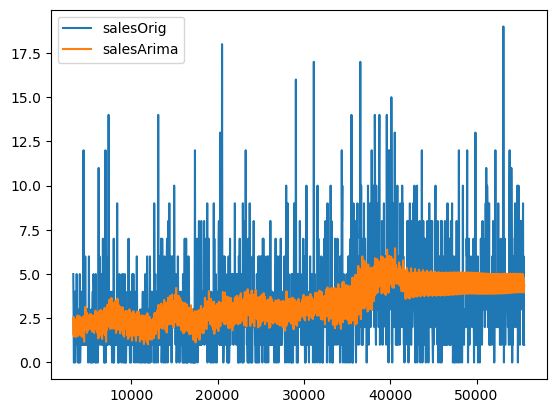

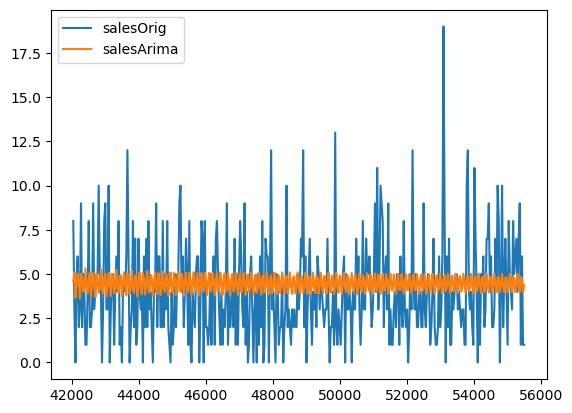

In [103]:
storeDf[['salesOrig','salesArima']].plot()
test_subDf[['salesOrig','salesArima']].plot()

In [ ]:
# check duplicated columns in flattened df
X_train0 = np.reshape(X_train, (X_train.shape[0], -1))
X_test0 = np.reshape(X_test, (X_test.shape[0], -1))   

f = []
for i in range(15):
    if i == 0:
        f = train_subDf[lagF].columns.to_list()
    f = f + train_subDf[lagF].columns.to_list()
f = np.array(f)   # get all columns in the falttened shape


_,i = np.unique(X_train0, axis = 1, return_index=True)
_,j = np.unique(X_test0, axis = 1, return_index=True)

missingIdx = []
for idx in i:
    if not idx in j:
        missingIdx.append(idx)

f[missingIdx]
X_test0[:,i]

In [ ]:
# compare against 16 lgbms one for each t+i (e.g. one for t+1, t+2, t+3,..)

# Set parameters for LGBM model
params = {
    'objective': 'regression',  # Assuming you're doing regression
    'metric': 'rmse',  # Mean squared error
    'num_leaves': 15,
    'learning_rate': 0.04,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}   


X_train0 = np.reshape(X_train, (X_train.shape[0], -1))
X_test0 = np.reshape(X_test, (X_test.shape[0], -1)) 

X_train0,i = np.unique(X_train0, axis = 1, return_index=True)
X_test0 = X_test0[:,i]

# Train the model
num_round = 100  
gbms = [lgb.train(params, lgb.Dataset(X_train0, label=y_train[:,i, :]),num_round, valid_sets=[lgb.Dataset(X_test0, label=y_test[:,i, :])]) for i in range(16)]


predtrainLGBM = [gbm.predict(X_train0, num_iteration=gbm.best_iteration) for i,gbm in enumerate(gbms)]
predtestLGBM = [gbm.predict(X_test0, num_iteration=gbm.best_iteration) for i,gbm in enumerate(gbms)]
print('transform log', logTransform, 'predict diff', predictDiff)
for i in range(16):
    print('timestamp:',i,'errors: ', calcLossLGBM(predtrainLGBM[i], y_train[:,i, :], logTransform, predictDiff, y_trainBase[:,i, :]), calcLossLGBM(predtestLGBM[i], y_test[:,i, :], logTransform, predictDiff, y_testBase[:,i, :]))

print('overall:','errors: ',calcLoss(np.reshape(np.column_stack(predtrainLGBM), y_trainBase.shape), y_train, logTransform, predictDiff, y_trainBase),calcLoss(np.reshape(np.column_stack(predtestLGBM),y_testBase.shape), y_test, logTransform, predictDiff, y_testBase))

for i in range(5):
    j = i*16
    plot(j, logTransform, np.reshape(np.column_stack(predtestLGBM), y_testBase.shape), y_test, predictDiff, y_testBase)


In [ ]:
allF

In [ ]:
# compare against base lgbm that just predicts always t+16

def calcLossLGBM(pred, y, logTransform, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred, (pred.shape[0],1)) + base
        y = y + base

    if logTransform:
        a = np.exp(pred)
        y = np.exp(y)
    else:
        a = (pred)
        y = (y)

    if (a < 0).any():
        a = np.clip(a, 0, 1e20)
    rmsleTrain = np.sqrt(mean_squared_log_error(a,y))
    return rmsleTrain
def plotLGBM(i, logTransform, pred, y, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred, (pred.shape[0],1)) + base
        y = y + base
    if logTransform:
        a = np.exp(pred[i:i+16])
        y = np.exp(y[i:i+16])
    else:
        a = (pred[i:i+16])
        y = (y[i:i+16])
    x = range(len(a))   

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axs.plot(x, y, color='blue',label='Original')
    axs.plot(x, a, color='red',label='pred')
    axs.set_title('index: '+str(i))
    fig.subplots_adjust(hspace=0.5)

# Set parameters for LGBM model
params = {
    'boosting':'gbdt',#'gbdt', #'rf' #'dart'
    'objective': 'regression',  # Assuming you're doing regression
    'metric': 'mse',  # Mean squared error
    'num_leaves': 15,
    #'lambda_l1': 0.1,
    #'lambda_l2': 0.2,
    #'max_depth':10,
    #'learning_rate': 0.1,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1,
    'force_col_wise':True,
    'num_iterations':200
}   

targetF = 'sales'
baseTrain, baseTest = [],[]
if predictDiff:
    targetF = 'target'
    baseTrain = train_subDf[['ref']].to_numpy()
    baseTest  = test_subDf[['ref']].to_numpy()
    

X_train0 = train_subDf[allF].to_numpy()
y_train0 = train_subDf[[targetF]].to_numpy()
X_test0 =  test_subDf[allF].to_numpy()
y_test0 =   test_subDf[[targetF]].to_numpy()           

# Train the model
gbm = lgb.train(params, lgb.Dataset(X_train0, label=y_train0), valid_sets=[lgb.Dataset(X_test0, label=y_test0)]#,num_boost_round=100
,callbacks=[lgb.early_stopping(stopping_rounds=30)]
)  
predtrainLGBM = gbm.predict(X_train0)#, num_iteration=gbm.best_iteration)
predtestLGBM = gbm.predict(X_test0)#, num_iteration=gbm.best_iteration)
print('transform log', logTransform, 'predict diff', predictDiff)
print('errors: ', calcLossLGBM(predtrainLGBM, y_train0, logTransform, predictDiff, baseTrain), calcLossLGBM(predtestLGBM, y_test0, logTransform, predictDiff, baseTest))

for i in range(1):
    plotLGBM(i*16, logTransform, predtestLGBM, y_test0, predictDiff, baseTest)
    plotLGBM(i*16, logTransform, predtrainLGBM, y_train0, predictDiff, baseTrain)


In [ ]:
# feature importances
importances = gbm.feature_importance()
for name, importance in zip(allF, importances):
    print(f'{name}: {importance}')

In [ ]:
cv_mod = lgb.cv(params, 
                lgb.Dataset(X_train0, label=y_train0), 
                50, 
                nfold = 10, 
                stratified = True)

### try arima for simple lagged
- not useable in general, but maybe combined with lgbm
- build an arima for sales & an arima for transactions!

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# build an arima for sales & an arima for transactions!

In [ ]:
f = 'transactions'# 'salesOrig' #target
y_trainArima = train_subDf[[f]].fillna(0)
y_testArima = test_subDf[[f]].fillna(0)

model = ARIMA(y_trainArima, order=(5, 0, 5))
model_fit = model.fit()

In [ ]:
def calcLossArima(fitted, y_train, logTransform):
    if not logTransform:
        rmsleTrain = np.sqrt(mean_squared_log_error(fitted,y_train))
    else:
        y_train = np.reshape(y_train, fitted.shape)
        rmsleTrain =  np.sqrt(np.mean((fitted-y_train)**2))
    return rmsleTrain

def plotArima(i, pred, y, len):
    y = np.reshape(y, pred.shape)
    x = range(len)   

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axs.plot(x, y[i:i+len], color='blue',label='Original')
    axs.plot(x, pred[i:i+len], color='red',label='pred')
    axs.set_title('index: '+str(i))
    fig.subplots_adjust(hspace=0.5)

In [ ]:
fitted_values = model_fit.fittedvalues
predicted_values = model_fit.forecast(steps=len(y_testArima))
print('errors: ', calcLossArima(fitted_values, y_trainArima, True), calcLossArima(predicted_values, y_testArima, True))
plotArima(0, predicted_values, y_testArima, 150)

In [ ]:
fitted_values = model_fit.fittedvalues
predicted_values = model_fit.forecast(steps=len(y_testArima))
print('errors: ', calcLossArima(fitted_values, y_trainArima, False), calcLossArima(predicted_values, y_testArima, False))
plotArima(0, predicted_values, y_testArima, 150)

### analyze residuals

ATTENTION:
if I try to fit just for the next day I already get big errors!

- holiday info is needed before & after holiday 
- check for transferred info, would be better if transferred signal is also indicated at day of peak


transaction might be helpful -> predict transaction first & then with transaction the sales
- doesn't seem like it

In [ ]:
def addStuffToDf(test_subDf, predtestLGBM, y_test0, baseTest, logTransform, predictDiff):
    test_subDf.loc[:,['day_name']] = test_subDf.date.dt.day_name()
    pred = np.reshape(predtestLGBM, (predtestLGBM.shape[0],1))
    y = y_test0
    test_subDf.loc[:,['pred0']] = pred
    test_subDf.loc[:,['y0']] = y

    if predictDiff:
        y = y + baseTest
        pred = pred + baseTest
        test_subDf.loc[:,['base']] = baseTest
    test_subDf.loc[:,['pred1']] = pred
    test_subDf.loc[:,['y1']] = y
    if logTransform:
        test_subDf.loc[:,['orig_sales']] = np.exp(y) -1
        test_subDf.loc[:,['pred']] = np.exp(pred) -1
    else:
        test_subDf.loc[:,['orig_sales']] = y
        test_subDf.loc[:,['pred']] =  pred
    return test_subDf

def plotDf(test_subDf,i):
    f = [#'sales',
            'orig_sales', 'onpromotion',
            #'dcoilwtico', 
            'holidayType',
           #'description', 
           'transferred', 'store_closed',
           #'linear_time', 
           #'day_of_year', 
           #'day_of_year_f12_0',
           #'day_of_year_f12_180', 'day_of_year_f104_0', 'day_of_year_f104_180',
           #'day_of_year_f24_0', 'day_of_year_f24_180', 'day_of_year_f52_0',
           #'day_of_year_f52_180', 
           'weekday', 
           'day_name','pred', #'pred0','y0'
           #'month'
           ]
    f2 =['transactions']
    f3 = ['pred0','y0', 'base'] if predictDiff else ['pred0','y0']
    #f2 = ['pred1','y1']

    test_subDf[f].iloc[i:i+50].plot()
    #test_subDf[f3].iloc[i:i+50].plot()
    #test_subDf[f2].iloc[i:i+50].plot()
    #test_subDf[['dcoilwtico']].iloc[i:i+50].plot()

In [ ]:
test_subDf = addStuffToDf(test_subDf, predtestLGBM, y_test0, baseTest, logTransform, predictDiff)
train_subDf = addStuffToDf(train_subDf, predtrainLGBM, y_train0, baseTrain, logTransform, predictDiff)

In [ ]:
for f in train_subDf.columns:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axs.scatter(train_subDf['sales'], train_subDf[f], color='blue',label='Original')
    axs.set_title(f)
    fig.subplots_adjust(hspace=0.5)


In [ ]:
plotDf(test_subDf, 50)


In [ ]:
for i in range(int(train_subDf.shape[0] / 50)):  
    plotDf(train_subDf, i*50)

In [ ]:
f0 = ['sales','orig_sales', 'onpromotion',
        #'dcoilwtico', 
        'holidayType',
       'description', 
       'transferred', 'store_closed',
       'weekday', 
       'day_name','pred', 'pred0','y0'
       #'month'
       ]

test_subDf[f0].head(50)

### NN approaches
way worse than lgbm, doesn't really learn anything, more like mean estimator..

In [ ]:
""" use a fully connected NN & lagged df for 1 lag!!-- way worse than lgbm"""

targetF = 'sales'
baseTrain, baseTest = [],[]
if predictDiff:
    targetF = 'target'
    baseTrain = train_subDf[['ref']].to_numpy()
    baseTest  = test_subDf[['ref']].to_numpy()
    

X_train0 = train_subDf[allF].to_numpy()
y_train0 = train_subDf[[targetF]].to_numpy()
X_test0 =  test_subDf[allF].to_numpy()
y_test0 =   test_subDf[[targetF]].to_numpy()   

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

tf.keras.utils.set_random_seed(42)

n_features = X_train0.shape[1]

model = Sequential()
model.add(Dense(n_features,input_shape=(n_features,)))
model.add(Dense(n_features))
model.add(Dense(n_features))
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
model.fit(X_train0, y_train0, epochs=100, batch_size=32,validation_data=(X_test0, y_test0))

predtrainLGBM = model.predict(X_train0)
predtestLGBM = model.predict(X_test0)
print('errors: ', calcLossLGBM(predtrainLGBM, y_train0, logTransform, predictDiff, baseTrain), calcLossLGBM(predtestLGBM, y_test0, logTransform, predictDiff, baseTest))

for i in range(1):
    plotLGBM(i*16, logTransform, predtestLGBM, y_test0, predictDiff, baseTest)
    plotLGBM(i*16, logTransform, predtrainLGBM, y_train0, predictDiff, baseTrain)

In [ ]:
""" use a fully connected NN  for sequence with 16"""
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

tf.keras.utils.set_random_seed(42)

n_features = X_train.shape[2]

model = Sequential()
model.add(Dense(64,input_shape=(n_predictedValues, n_features)))
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))

predtrain = model.predict(X_train, verbose=False)
predtest  = model.predict(X_test, verbose=False)

print('errors: ', calcLoss(predtrain, y_train, logTransform, predictDiff, y_trainBase), calcLoss(predtest, y_test, logTransform, predictDiff, y_testBase))


In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

tf.keras.utils.set_random_seed(42)

n_features = X_train.shape[2]

model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(n_predictedValues, n_features)))
model.add(GRU(64,return_sequences=False))
#model.add(Dense(64))
model.add(Dense(n_predictedValues))
#model.add(TimeDistributed(Dense(1)))

model.compile(loss=root_mean_squared_error, optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_test, y_test))

predtrain = model.predict(X_train, verbose=False)
predtest  = model.predict(X_test, verbose=False)

print('errors: ', calcLoss(predtrain, y_train, logTransform, predictDiff, y_trainBase),calcLoss(predtest, y_test, logTransform, predictDiff, y_testBase))


In [ ]:
def calcLoss(pred, y, logTransform, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred,base.shape) + base
        y = y + base
    if logTransform:
        a = np.exp(pred)
        y = np.exp(y)
    else:
        a = (pred)
        y = (y)

    if (a < 0).any():
        a = np.clip(a, 0, 1e20)
    rmsleTrain = np.sqrt(mean_squared_log_error(np.reshape(a,(-1,n_predictedValues)), np.reshape(y, (-1,n_predictedValues))))
    return rmsleTrain
    
predtrain = model.predict(X_train, verbose=False)
predtest  = model.predict(X_test, verbose=False)

print('errors: ', calcLoss(predtrain, y_train, logTransform, predictDiff, y_trainBase), calcLoss(predtest, y_test, logTransform, predictDiff, y_testBase))


In [ ]:

def plot(i, logTransform, pred, y, predictDiff, base):
    if predictDiff:
        pred = np.reshape(pred,base.shape) + base
        y = y + base
    if logTransform:
        a = np.exp(pred[i,:])
        y = np.exp(y[i,:])
    else:
        a = (pred[i,:])
        y = (y[i,:])
    x = range(len(a))   

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axs.plot(x, y, color='blue',label='Original')
    axs.plot(x, a, color='red',label='pred')
    axs.set_title('index: '+str(i))
    fig.subplots_adjust(hspace=0.5)

for i in range(5):
    plot(i*10, logTransform, predtest, y_test, predictDiff, y_testBase)

# LSTM

In [ ]:
tf.keras.utils.set_random_seed(42)

# Define an input sequence.
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# Create a LSTM layer
encoder = LSTM(latent_dim, return_state=True)

# Get the output and states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# Create another LSTM layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Get the output and states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Create a dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# Get the final output
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


# XGBoost